In [8]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}

In [10]:
sepadd = 2
eqb = dict()

for design in designs:  
    eqb[design] = dict()
    for side in ["iu", "ou"]:
        eqb[design][side] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 10000)

eqb["SPR38_hiq"] = copy.deepcopy(eqb["SPR38"])

print("Complete")

Complete


In [11]:
for side in ["iu", "ou"]:
    for design in designs:
    
        print("Avg B of {}, {}: {:.3f}".format(design, side, np.mean(eqb[design][side]["Btot"][:eqb[design][side]["Xpoint"]])))

Avg B of V10, iu: 4.133
Avg B of V10X, iu: 4.602
Avg B of SPR38, iu: 3.902
Avg B of V10, ou: 2.432
Avg B of V10X, ou: 2.464
Avg B of SPR38, ou: 2.306


In [16]:
for side in ["iu", "ou"]:
    for design in designs:
        d = eqb[design][side]
        print("Lm of {}, {}: {:.3f}".format(design, side, d["S"][-1] - d["S"][d["Xpoint"]]))

Lm of V10, iu: 33.925
Lm of V10X, iu: 34.094
Lm of SPR38, iu: 54.052
Lm of V10, ou: 20.169
Lm of V10X, ou: 24.716
Lm of SPR38, ou: 35.382


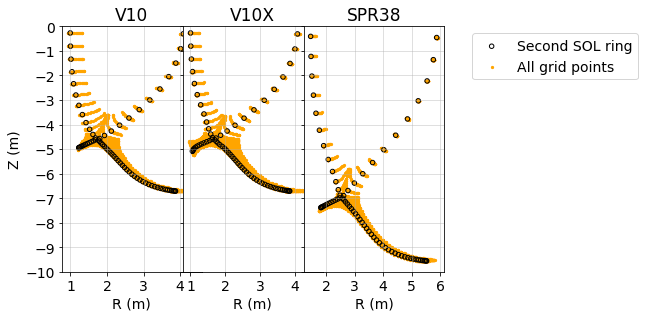

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(5,3), sharey = True)
fig.tight_layout(pad=-2)
for i, design in enumerate(designs):
    data = eqb[design]["ou"]

    axes[i].scatter(data["R_ring"], data["Z_ring"], zorder = 1, color = "black", s = 20, facecolor="None", label = "Second SOL ring")
    axes[i].scatter(data["R_full"], data["Z_full"], alpha = 1, zorder = 0, color = "orange", s = 5, label = "All grid points")
    axes[i].set_ylim(-10, 0)
    axes[i].set_title(design, fontsize = 17)
    axes[i].grid(alpha=0.5)
    axes[i].set_xlabel("R (m)")
    axes[i].xaxis.set_major_locator(MultipleLocator(1))
    axes[i].yaxis.set_major_locator(MultipleLocator(1))

axes[0].set_ylabel("Z (m)")
    
axes[-1].legend(bbox_to_anchor=(1.15,1))

# Front profile comparisons

In [12]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Baseline v10

In [6]:
s = dict()

In [7]:
def run(grid, store_cases, list_cvars):
    store = dict()
    for side in ["iu","ou"]:
        store[side] = dict()
        print("Side {}...".format(side))

        for cvar in list_cvars:
            store[side][cvar] = [0]*len(store_cases)
            print(f"{cvar}")

            for i, case in enumerate(store_cases):
                print("Case", case)

                d = grid[side].copy()
                constants = constants_default.copy()
                radios = radios_default.copy()
                constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
                if type(case) == dict:
                    for key in case.keys():
                        constants[key] = case[key]

                constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
                SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
                indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
                out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                    Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                    control_variable = cvar)
                store[side][cvar][i] = out 
                store["cases"] = store_cases
    return store


In [10]:
store_cases = [["default"]]
s["base_ne"] = run(eqb["V10"], store_cases, ["density"])

Side iu...
density
Case ['default']
Solving...0...105...193...266...326...375...416...449...474...493...508...522...534...546...557...Complete in 37.3 seconds
Side ou...
density
Case ['default']
Solving...0...342...600...822...1027...1215...1379...1511...1611...1685...1738...1776...1803...1821...1835...Complete in 27.6 seconds


## All design/variables

In [19]:
list_cvars = ["density", "power", "impurity_frac"]
list_designs = ["V10", "V10X", "SPR38", "SPR38_hiq"]
# list_designs = ["SPR38_hiq"]
hiq_multiplier = 220/100

store = dict()

for design in list_designs:
    store[design] = dict()
    print("Design {}...".format(design), end = "")
    
    for cvar in list_cvars:
        store[design][cvar] = dict()
        print(f"Variable {cvar}...", end = "")
    
        for side in ["iu","ou"]:
            print("Side {}...".format(side))

            d = eqb[design][side].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()
            constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
            
            if design == "SPR38_hiq":
                q_mult = 220/100
            else:
                q_mult = 1
            
            if side == "iu":
                constants["qpllu0"] = 1e8*q_mult
            elif side == "ou":
                constants["qpllu0"] = 1e9*q_mult
            
            store[design][cvar][side] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

allscan = copy.deepcopy(store)

Design V10...Variable density...Side iu...
Solving...0...211...387...533...654...753...834...900...949...987...1019...1046...1070...1093...1116...Complete in 29.4 seconds
Side ou...
Solving...0...687...1205...1652...2063...2441...2768...3031...3231...3377...3482...3557...3609...3644...3673...Complete in 23.2 seconds
Variable power...Side iu...
Solving...0...211...387...533...654...753...834...900...949...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


987...1019...1046...1070...1093...1116...Complete in 36.9 seconds
Side ou...
Solving...0...687...1205...1652...2063...2441...2768...3031...3231...3377...3482...3557...3609...3644...3673...Complete in 24.1 seconds
Variable impurity_frac...Side iu...
Solving...0...211...387...533...654...753...834...900...949...987...1019...1046...1070...1093...1116...Complete in 23.7 seconds
Side ou...
Solving...0...687...1205...1652...2063...2441...2768...3031...3231...3377...3482...3557...3609...3644...3673...Complete in 24.4 seconds
Design V10X...Variable density...Side iu...
Solving...0...187...345...500...661...821...970...1101...1210...1289...1347...1393...1432...1469...1509...Complete in 32.0 seconds
Side ou...
Solving...0...784...1368...1879...2343...2737...3037...3248...3381...3473...3542...3590...3623...3648...3670...Complete in 24.7 seconds
Variable power...Side iu...
Solving...0...187...345...500...661...821...970...1101...1210...1289...1347...1393...1432...1469...1509...Complete in 33.4 sec

In [20]:
file_write(allscan, "6-allscan.pkl")

In [13]:
allscan = file_read("6-allscan.pkl")

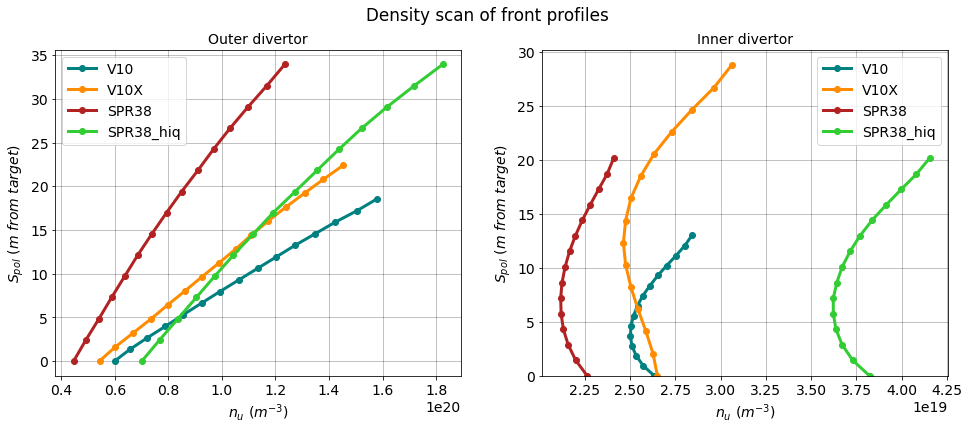

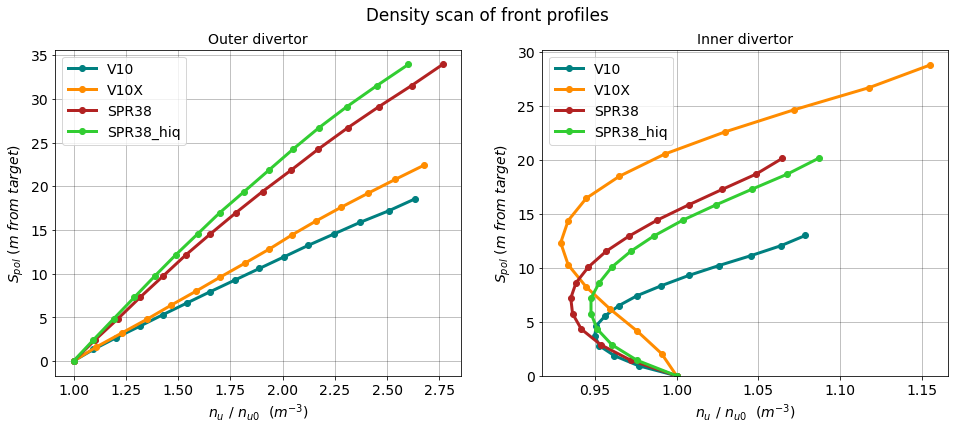

In [14]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

colors = mike_cmap(4)
list_designs = ["V10", "V10X", "SPR38", "SPR38_hiq"]
cvar = "density"

for basis in ["cvar", "crel"]:
    
    fig, axes = plt.subplots(1,2, figsize = (16,6))
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]
    
    for k, design in enumerate(list_designs):
        for i, side in enumerate(["ou", "iu"]):
            o = allscan[design][cvar][side].copy()
            
            axes[i].plot(o[basis], o["Splot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])

    ylims = axes[1].get_ylim()
    axes[1].set_ylim(0,ylims[1])

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend()
        
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")
    


In [15]:
# mvar[side][design][control_variable] = out
list_cvars = ["impurity_frac", "density", "power"]

for side in ["iu", "ou"]:
    for cvar in list_cvars:
        for design in list_designs:
            window_ratio = allscan[design][cvar][side]["window_ratio"]
            threshold = allscan[design][cvar][side]["threshold"]
            print(f"{cvar}, {side}, {design}, window {window_ratio:.3f}, threshold {threshold:.3E}")

# mvar["iu"]["SPR38"]["density"]["window_ratio"]

impurity_frac, iu, V10, window 1.160, threshold 1.390E-03
impurity_frac, iu, V10X, window 1.334, threshold 1.404E-03
impurity_frac, iu, SPR38, window 1.133, threshold 1.025E-03
impurity_frac, iu, SPR38_hiq, window 1.183, threshold 2.922E-03
density, iu, V10, window 1.079, threshold 2.634E+19
density, iu, V10X, window 1.155, threshold 2.651E+19
density, iu, SPR38, window 1.065, threshold 2.263E+19
density, iu, SPR38_hiq, window 1.087, threshold 3.823E+19
power, iu, V10, window 0.900, threshold 1.198E+07
power, iu, V10X, window 0.755, threshold 1.314E+07
power, iu, SPR38, window 0.862, threshold 9.617E+06
power, iu, SPR38_hiq, window 0.842, threshold 1.276E+07
impurity_frac, ou, V10, window 6.952, threshold 7.201E-03
impurity_frac, ou, V10X, window 7.177, threshold 5.892E-03
impurity_frac, ou, SPR38, window 7.645, threshold 3.996E-03
impurity_frac, ou, SPR38_hiq, window 6.791, threshold 9.830E-03
density, ou, V10, window 2.632, threshold 5.996E+19
density, ou, V10X, window 2.676, thresho

## All design/variables N

In [13]:
list_cvars = ["density", "power", "impurity_frac"]
list_designs = ["V10", "V10X", "SPR38"]
# list_designs = ["SPR38_hiq"]
hiq_multiplier = 220/100

store = dict()

for design in list_designs:
    store[design] = dict()
    print("Design {}...".format(design), end = "")
    
    for cvar in list_cvars:
        store[design][cvar] = dict()
        print(f"Variable {cvar}...", end = "")
    
        for side in ["iu","ou"]:
            print("Side {}...".format(side))

            d = eqb[design][side].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()
            constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
            constants["Lfunc"] = LfuncN
            if design == "SPR38_hiq":
                q_mult = 220/100
            else:
                q_mult = 1
            
            if side == "iu":
                constants["qpllu0"] = 1e8*q_mult
            elif side == "ou":
                constants["qpllu0"] = 1e9*q_mult
            
            store[design][cvar][side] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

allscanN = copy.deepcopy(store)

Design V10...Variable density...Side iu...
Solving...0...211...387...533...654...753...834...900...949...987...1019...1046...1070...1093...1116...Complete in 13.1 seconds
Side ou...
Solving...0...687...1205...1652...2063...2441...2768...3031...3231...3377...3482...3557...3609...3644...3673...Complete in 12.2 seconds
Variable power...Side iu...
Solving...0...211...387...533...654...753...834...900...949...987...1019...1046...1070...1093...1116...Complete in 15.7 seconds
Side ou...
Solving...0...687...1205...1652...2063...2441...2768...3031...3231...3377...3482...3557...3609...3644...3673...Complete in 11.7 seconds
Variable impurity_frac...Side iu...
Solving...0...211...387...533...654...753...834...900...949...987...1019...1046...1070...1093...1116...Complete in 12.5 seconds
Side ou...
Solving...0...687...1205...1652...2063...2441...2768...3031...3231...3377...3482...3557...3609...3644...3673...Complete in 11.3 seconds
Design V10X...Variable density...Side iu...
Solving...0...187...345.

In [10]:
file_write(allscanN, "6-allscanN.pkl")

In [18]:
# mvar[side][design][control_variable] = out
list_cvars = ["impurity_frac", "density", "power"]
store = allscanN

for side in ["iu", "ou"]:
    for cvar in list_cvars:
        for design in store.keys():
            window_ratio = store[design][cvar][side]["window_ratio"]
            threshold = store[design][cvar][side]["threshold"]
            print(f"{cvar}, {side}, {design}, window {window_ratio:.3f}, threshold {threshold:.3E}")
        print("")

# mvar["iu"]["SPR38"]["density"]["window_ratio"]

impurity_frac, iu, V10, window 1.021, threshold 3.792E-03
impurity_frac, iu, V10X, window 1.059, threshold 4.267E-03
impurity_frac, iu, SPR38, window 0.952, threshold 3.051E-03

density, iu, V10, window 1.010, threshold 4.355E+19
density, iu, V10X, window 1.030, threshold 4.619E+19
density, iu, SPR38, window 0.975, threshold 3.906E+19

power, iu, V10, window 1.025, threshold 6.325E+06
power, iu, V10X, window 0.989, threshold 6.043E+06
power, iu, SPR38, window 1.049, threshold 4.411E+06

impurity_frac, ou, V10, window 8.886, threshold 2.085E-02
impurity_frac, ou, V10X, window 9.472, threshold 1.740E-02
impurity_frac, ou, SPR38, window 10.763, threshold 1.273E-02

density, ou, V10, window 2.983, threshold 1.021E+20
density, ou, V10X, window 3.086, threshold 9.316E+19
density, ou, SPR38, window 3.276, threshold 7.988E+19

power, ou, V10, window 0.351, threshold 4.854E+07
power, ou, V10X, window 0.331, threshold 4.343E+07
power, ou, SPR38, window 0.310, threshold 3.538E+07



In [37]:
# mvar[side][design][control_variable] = out
list_cvars = ["impurity_frac", "density", "power"]
store = allscanN

for side in ["iu", "ou"]:
    for cvar in list_cvars:
        for design in store.keys():
            window_ratio = store[design][cvar][side]["window_ratio"]
            threshold = store[design][cvar][side]["threshold"]
            print(f"{cvar}, {side}, {design}, window {window_ratio:.3f}, threshold {threshold:.3E}")

# mvar["iu"]["SPR38"]["density"]["window_ratio"]

impurity_frac, iu, V10, window 1.021, threshold 3.792E-03
impurity_frac, iu, V10X, window 1.059, threshold 4.267E-03
impurity_frac, iu, SPR38, window 0.952, threshold 3.051E-03
density, iu, V10, window 1.010, threshold 4.355E+19
density, iu, V10X, window 1.030, threshold 4.619E+19
density, iu, SPR38, window 0.975, threshold 3.906E+19
power, iu, V10, window 1.025, threshold 6.325E+06
power, iu, V10X, window 0.989, threshold 6.043E+06
power, iu, SPR38, window 1.049, threshold 4.411E+06
impurity_frac, ou, V10, window 8.886, threshold 2.085E-02
impurity_frac, ou, V10X, window 9.472, threshold 1.740E-02
impurity_frac, ou, SPR38, window 10.763, threshold 1.273E-02
density, ou, V10, window 2.983, threshold 1.021E+20
density, ou, V10X, window 3.086, threshold 9.316E+19
density, ou, SPR38, window 3.276, threshold 7.988E+19
power, ou, V10, window 0.351, threshold 4.854E+07
power, ou, V10X, window 0.331, threshold 4.343E+07
power, ou, SPR38, window 0.310, threshold 3.538E+07


# Invert power

In [7]:
list_designs

NameError: name 'list_designs' is not defined

In [5]:
allscan = file_read("6-allscan.pkl")
for design in list_designs:
    for side in ["iu", "ou"]:
        allscan[design]["power"][side]["crel"] = 1/allscan[design]["power"][side]["crel"]


NameError: name 'list_designs' is not defined

# Baseline V10

## Front profiles

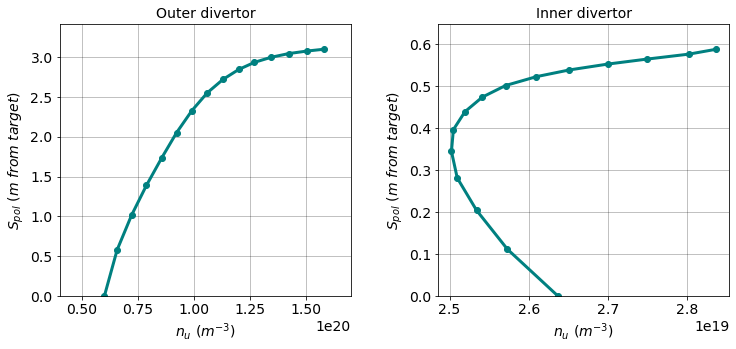

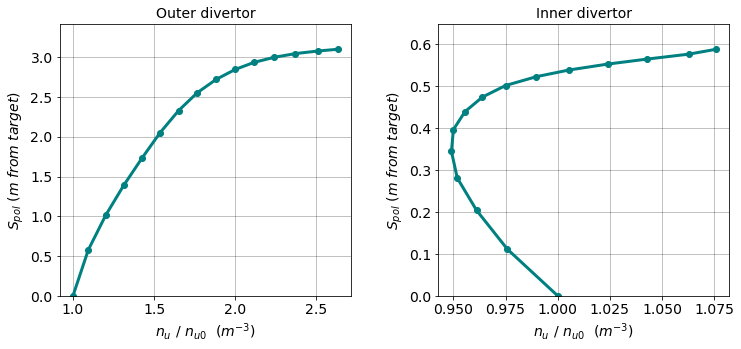

In [210]:
# labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(3)
cvar = "density"
design = "V10"

for basis in ["cvar", "crel"]:
    
    fig, axes = plt.subplots(1,2, figsize = (12,5))
    plt.subplots_adjust(hspace=.25, wspace = 0.3)
    # fig.suptitle("Density scan of front profiles")
    ax = axes[0]
    for k, case in enumerate(store_cases):
        for i, side in enumerate(["ou", "iu"]):
            o = allscan[design][cvar][side].copy()
            
            if basis == "crel":
                axes[i].plot(o[basis], o["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])
            else:
                axes[i].plot(o[basis], o["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])
          
    ylims = axes[1].get_ylim()
    axes[1].set_ylim(0,ylims[1])
    
    if basis == "cvar":
        axes[0].set_xlim(0.4e20,1.7e20)
        # axes[1].set_xlim(1e20,1.30e20)

    for ax in axes:
        ylims = ax.get_ylim()
        ax.set_ylim(0,ylims[1]+ylims[1]*0.05)
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        # ax.legend()
        
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")
    


## Control variables

Text(0.5, 1.0, 'Inner divertor')

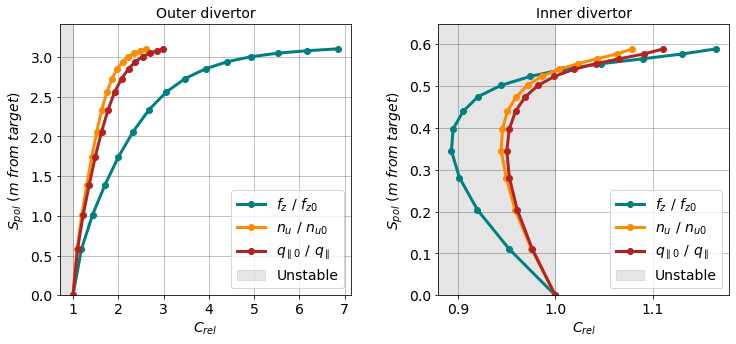

In [30]:
colors = mike_cmap(3)
cvar = "power"
design = "V10"
basis = "crel"
    
fig, axes = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace=.25, wspace = 0.3)

x = "SpolPlot"
ax = axes[0]
for k, cvar in enumerate(list_cvars):
    for i, side in enumerate(["ou", "iu"]):
        o = allscan[design][cvar][side].copy()

        if basis == "crel":
            axes[i].plot(o[basis], o[x],  marker = "o", label = store_names[cvar], markersize = 6, linewidth = 3, color = colors[k])
        else:
            axes[i].plot(o[basis], o[x],  marker = "o", label = store_names[cvar], markersize = 6, linewidth = 3, color = colors[k])

ylims = axes[1].get_ylim()
axes[1].set_ylim(0,ylims[1])
axes[0].xaxis.set_major_locator(MultipleLocator(1))
axes[1].xaxis.set_major_locator(MultipleLocator(0.1))

for ax in axes:
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C_{rel}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend()

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")


Text(0.5, 1.0, 'Inner divertor')

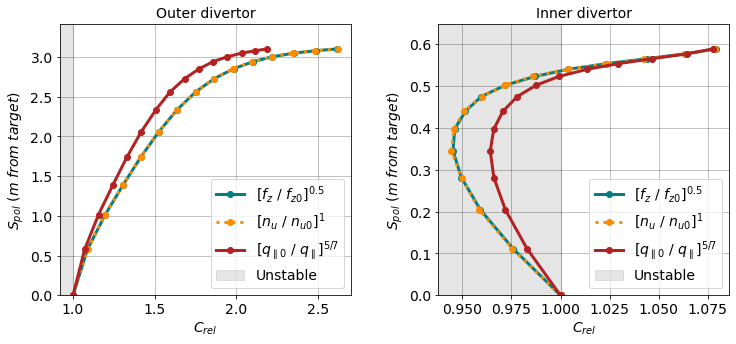

In [32]:
colors = mike_cmap(3)
cvar = "power"
design = "V10"
basis = "crel"
    
fig, axes = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace=.25, wspace = 0.3)

scaling_factors = {"density":1, "power":5/7, "impurity_frac":0.5}
style = ["solid", "dotted", "solid"]

x = "SpolPlot"
ax = axes[0]
for k, cvar in enumerate(list_cvars):
    for i, side in enumerate(["ou", "iu"]):
        o = allscan[design][cvar][side].copy()

        if basis == "crel":
            axes[i].plot(o[basis]**scaling_factors[cvar], o[x],  marker = "o", label = store_cnames[cvar], markersize = 6, linewidth = 3, color = colors[k], linestyle = style[k])
        else:
            axes[i].plot(o[basis]**scaling_factors[cvar], o[x],  marker = "o", label = store_cnames[cvar], markersize = 6, linewidth = 3, color = colors[k])

ylims = axes[1].get_ylim()
axes[1].set_ylim(0,ylims[1])

for ax in axes:
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C_{rel}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend()

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")


In [157]:
store_labels["cvar"].keys()

dict_keys(['density', 'power', 'impurity_frac'])

## Window sensitivity

### Single band

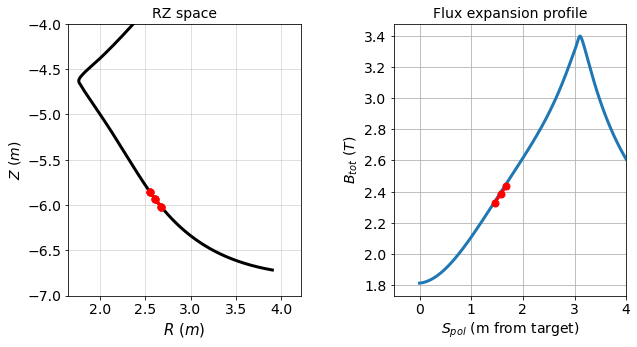

In [193]:
side = "ou"
design = "V10"
cvar = "impurity_frac"
o = allscan[design][cvar][side]
d = eqb[design][side]

fig, axes = plt.subplots(1,2, figsize = (10,5))
plt.subplots_adjust(hspace=.25, wspace = 0.4)
k = 6

band = make_window_band(d, o, 1.5)

ax = axes[0]
ax.plot(d["R"], d["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
if design == "SPR38":
    ax.set_ylim(-10,-6)

else:
    ax.set_ylim(-7, -4)
ax.grid(alpha = 0.5)
ax.set_title("RZ space")
color = "red"
for point in range(3):
    ax.plot(band["R"], band["Z"]*-1, markersize = 7, marker = "o", linewidth = 3, color = color)
    
    
ax = axes[1]
ax.plot(d["Spol"], d["Btot"]); ax.plot(band["Spol"], band["Btot"], marker = "o", color = color, markersize = 7, linewidth = 3); 
ax.set_xlabel("$S_{pol}$ (m from target)"); ax.set_ylabel("$B_{tot}\ (T)$")
ax.set_title("Flux expansion profile")
ax.set_xlim(-0.5,4)

axes[0].xaxis.set_major_locator(MultipleLocator(0.5))

### Band scan

Text(0, 0.5, '5% Fluctuation detachment band (m)')

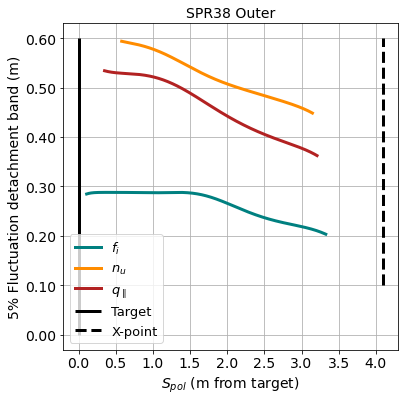

In [25]:
side = "ou"
design = "SPR38"
cvar = "power"

cvar_labels = {"power":"$q_{\parallel}$", "density":"$n_u$", "impurity_frac":"$f_i$"}
d = eqb[design][side]

fig, ax = plt.subplots(figsize = (6,6))
widths = dict()
Btot_avg = dict()
Btot_grad_avg = dict()
k = 0 
Xpoint = d["Xpoint"]
Spolx = d["Spol"][Xpoint]
Spol = d["Spol"]
colors = mike_cmap(3)

for k, cvar in enumerate(list_cvars):

    o = allscan[design][cvar][side]
    Spol_lims = [Spolx*0.1, Spolx*0.8]
    widths[k] = []
    Btot_avg[k] = []
    Btot_grad_avg[k] = []
    
    if cvar == "power":
        qbool = True
    else:
        qbool = False

    for s in Spol[:Xpoint]:

        band = make_window_band(d,o,s, q = qbool)
        if \
        band["Spol"][0] < Spol_lims[0] or \
        band["Spol"][2] > Spol_lims[1] or \
        band["width_pol"] < 0:
            widths[k].append(np.nan)
            Btot_avg[k].append(np.nan)
            Btot_grad_avg[k].append(np.nan)
        else:
            widths[k].append(band["width_pol"])
            Btot_avg[k].append(band["Btot_avg"])
            Btot_grad_avg[k].append(band["Btot_grad_avg"])        

    ax.plot(Spol[:Xpoint], widths[k], color = colors[k], label = cvar_labels[cvar])
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
ax.vlines(0, 0.0, 0.60, color = "black", linestyle = "solid", label = "Target")  
ax.vlines(Spolx, 0.10, 0.60, color = "black", linestyle = "dashed", label = "X-point")

ax.set_title("SPR38 Outer")
ax.legend(fontsize = 13)
ax.set_xlabel("$S_{pol}$ (m from target)"); ax.set_ylabel("5% Fluctuation detachment band (m)")

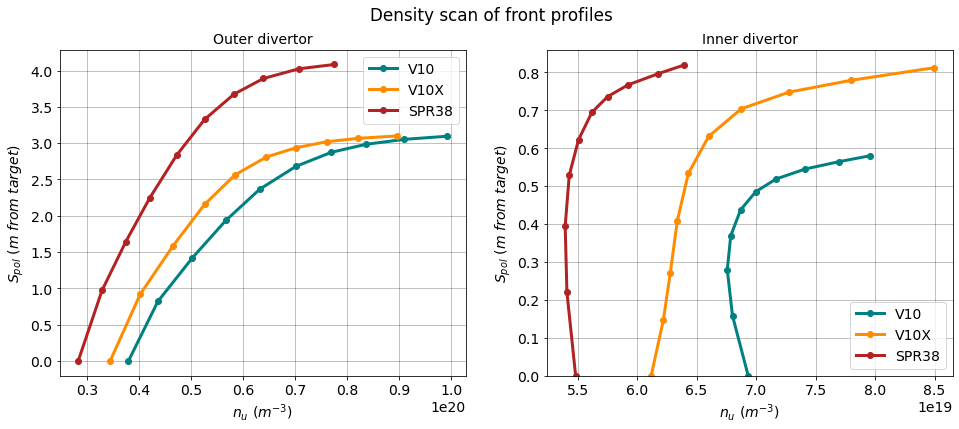

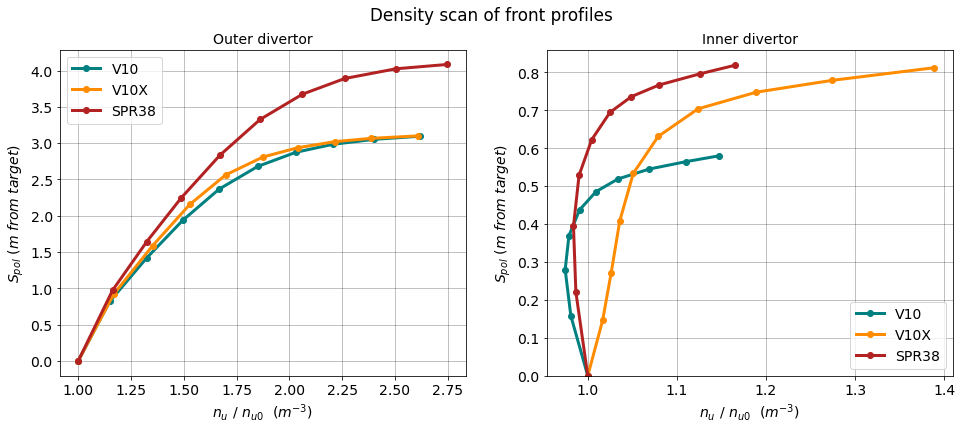

In [31]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(3)

# for basis in ["cvar_trim", "crel_trim"]:
for basis in ["cvar", "crel"]:
    
    fig, axes = plt.subplots(1,2, figsize = (16,6))
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]
    for k, design in enumerate(designs):
        for i, side in enumerate(["ou", "iu"]):
            o = ne_kAr[side][design].copy()
            
            if basis == "crel":
                axes[i].plot(o[basis], o["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])
            else:
                axes[i].plot(o[basis], o["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])
          

    ylims = axes[1].get_ylim()
    axes[1].set_ylim(0,ylims[1])

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend()
        
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")
    


# Part 3: all variables, numerical results

In [32]:
mvar = dict()

for side in ["iu","ou"]:
    mvar[side] = dict()
    print("Side {}...".format(side))
    
    for design in eqb[side].keys():
        mvar[side][design] = dict()
        print("Design {}...".format(design))
        
        for control_variable in ["impurity_frac", "density", "power"]:
            print(f"Solving {control_variable}...")
            
            d = eqb[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            indexRange = [0, d["Xpoint"]-1]

            constants["Lfunc"] = LfuncKallenbachAr        
            out = LRBv21(constants,radios,d["S"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = control_variable)

            out["SpolPlot"] = [d["Spol"][x] for x in indexRange]

            mvar[side][design][control_variable] = out

Side iu...
Design V10...
Solving impurity_frac...


TypeError: LRBv21() missing 1 required positional argument: 'indexRange'

In [18]:
mvar["iu"]["V10"]["impurity_frac"]["threshold"]

0.02407401426423986

In [22]:
# mvar[side][design][control_variable] = out
list_cvars = ["impurity_frac", "density", "power"]

for cvar in list_cvars:
    for side in ["iu", "ou"]:
        for design in designs:
            window_ratio = mvar[side][design][cvar]["window_ratio"]
            threshold = mvar[side][design][cvar]["threshold"]
            print(f"{cvar}, {side}, {design}, window {window_ratio:.3f}, threshold {threshold:.3E}")
        
# mvar["iu"]["SPR38"]["density"]["window_ratio"]

impurity_frac, iu, V10, window 1.278, threshold 2.407E-02
impurity_frac, iu, V10X, window 1.900, threshold 1.872E-02
impurity_frac, iu, SPR38, window 1.318, threshold 1.505E-02
impurity_frac, ou, V10, window 6.588, threshold 7.186E-03
impurity_frac, ou, V10X, window 6.754, threshold 5.857E-03
impurity_frac, ou, SPR38, window 7.211, threshold 3.990E-03
density, iu, V10, window 1.130, threshold 6.938E+19
density, iu, V10X, window 1.379, threshold 6.118E+19
density, iu, SPR38, window 1.147, threshold 5.488E+19
density, ou, V10, window 2.560, threshold 3.799E+19
density, ou, V10X, window 2.598, threshold 3.428E+19
density, ou, SPR38, window 2.685, threshold 2.822E+19
power, iu, V10, window 0.836, threshold 4.678E+07
power, iu, V10X, window 0.636, threshold 5.661E+07
power, iu, SPR38, window 0.803, threshold 4.055E+07
power, ou, V10, window 0.336, threshold 1.536E+08
power, ou, V10X, window 0.331, threshold 1.438E+08
power, ou, SPR38, window 0.317, threshold 1.274E+08


# Mesh study

## Base

In [83]:
store = dict()

for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for design in designs:
        print("Design {}...".format(design))
        
        d = eqb[side][design].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()

        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        constants["qpllu0"] = 1e9
        constants["Lfunc"] = LfuncKallenbachAr        
        out = LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                            control_variable = "density")
        
        out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
        
        store[side][design] = out
        
meshstudy_base = store

Side iu...
Design V10...
Solving...0...30...53...70...83...92...98...103...107...110...Complete in 13.6 seconds
Design V10X...
Solving...0...27...50...75...98...116...129...137...143...149...Complete in 15.0 seconds
Design SPR38...
Solving...0...28...50...67...79...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


88...93...97...101...104...Complete in 14.5 seconds
Side ou...
Design V10...
Solving...0...97...168...229...280...317...340...353...361...366...Complete in 11.3 seconds
Design V10X...
Solving...0...108...187...254...302...331...346...356...361...365...Complete in 12.0 seconds
Design SPR38...
Solving...0...81...137...187...236...277...306...324...335...340...Complete in 14.8 seconds


## log 1k

In [84]:
store = dict()

for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for design in designs:
        print("Design {}...".format(design))
        
        d = eqblog1k[side][design].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()

        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        constants["Lfunc"] = LfuncKallenbachAr  
        constants["qpllu0"] = 1e9
        out = LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                            control_variable = "density")
        
        out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
        
        store[side][design] = out
        
meshstudy_log1k = store

Side iu...
Design V10...
Solving...0...398...442...464...477...485...491...494...497...499...Complete in 13.9 seconds
Design V10X...
Solving...0...371...418...447...467...480...488...493...496...499...Complete in 14.4 seconds
Design SPR38...
Solving...0...403...445...466...479...486...491...494...

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


497...499...Complete in 16.3 seconds
Side ou...
Design V10...
Solving...0...414...448...467...480...488...493...496...498...499...Complete in 10.6 seconds
Design V10X...
Solving...0...420...453...473...485...491...495...497...498...499...Complete in 13.3 seconds
Design SPR38...
Solving...0...410...442...461...474...484...491...495...498...499...Complete in 12.9 seconds


## log 100k

In [85]:
store = dict()

for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for design in designs:
        print("Design {}...".format(design))
        
        d = eqblog100k[side][design].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()

        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        constants["qpllu0"] = 1e9
        
        constants["Lfunc"] = LfuncKallenbachAr        
        out = LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                            control_variable = "density")

        out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
        
        store[side][design] = out
        
meshstudy_log100k = store

Side iu...
Design V10...
Solving...0...40052...44436...46597...47866...48663...49163...49494...49751...49999...Complete in 55.3 seconds
Design V10X...
Solving...0...37336...42027...44962...46934...48200...48955...49380...49685...49999...Complete in 60.1 seconds
Design SPR38...
Solving...0...40583...44755...46821...48035...48784...49226...49511...49748...49999...Complete in 56.4 seconds
Side ou...
Design V10...
Solving...0...41834...45207...47142...48384...49126...49548...49786...49922...49999...Complete in 50.6 seconds
Design V10X...
Solving...0...42639...46018...47897...48935...49444...49700...49854...49943...49999...Complete in 51.5 seconds
Design SPR38...
Solving...0...41406...44586...46473...47851...48806...49396...49732...49911...49999...Complete in 51.8 seconds


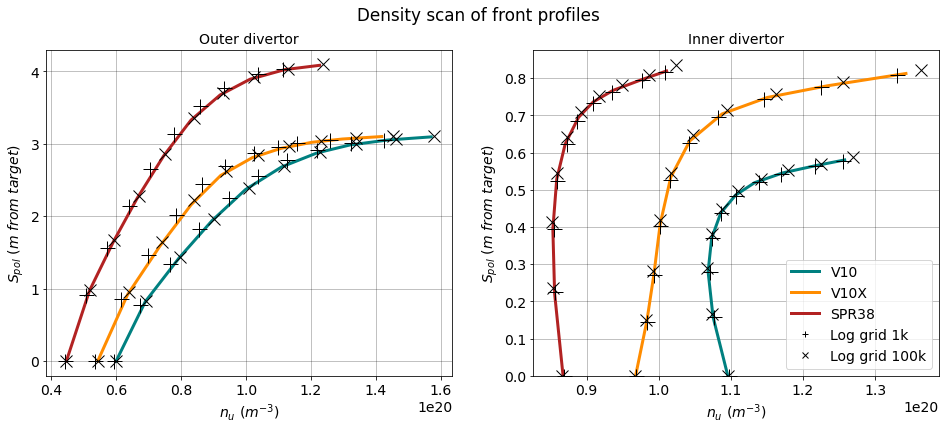

In [87]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
# labels = {"cvar":"$q_{\parallel}\ (Wm^{-2})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(3)

basis = "cvar"

fig, axes = plt.subplots(1,2, figsize = (16,6))
fig.suptitle("Density scan of front profiles")
ax = axes[0]
for k, design in enumerate(designs):
    for i, side in enumerate(["ou", "iu"]):
        o = meshstudy_base[side][design].copy()
        axes[i].plot(o[basis], o["SpolPlot"],  marker = "o", label = design, markersize = 0, linewidth = 3, color = colors[k])
        
        o = meshstudy_log1k[side][design].copy()
        axes[i].plot(o[basis], o["SpolPlot"],  marker = "+", linestyle = "dotted", 
                     zorder = 100, color = "black", markersize = 15, linewidth = 0)
        
        o = meshstudy_log100k[side][design].copy()
        axes[i].plot(o[basis], o["SpolPlot"],  marker = "x", linestyle = "dashed", 
                     zorder = 100,  color = "black", markersize = 12, linewidth = 0)

ylims = axes[1].get_ylim()
axes[1].set_ylim(0,ylims[1])

for ax in axes:
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel(labels[basis])
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")
    
legend_elements = [mpl.lines.Line2D([0], [0], color=colors[0], lw=3, label='V10'),
                   mpl.lines.Line2D([0], [0], color=colors[1], lw=3, label="V10X"),
                   mpl.lines.Line2D([0], [0], color=colors[2], lw=3, label="SPR38"),
                   mpl.lines.Line2D([0], [0], color= "black", linestyle = "dashed", lw=0, marker = "+", label="Log grid 1k"),
                   mpl.lines.Line2D([0], [0], color= "black", linestyle = "dotted", lw=0, marker = "x", label="Log grid 100k")]

axes[1].legend(handles = legend_elements)


In [38]:
meshstudy_base["ou"]["V10"]["constants"]

{'gamma_sheath': 7,
 'qpllu0': 250000000.0,
 'nu': 1e+20,
 'nu0': 1e+20,
 'cz0': 0.02,
 'kappa0': 2500,
 'mi': 3e-27,
 'echarge': 1.6000000000000002e-19,
 'Tt': 0.5,
 'Lfunc': <function AnalyticCoolingCurves.LfuncKallenbachAr(T)>,
 'alpha': 1000,
 'XpointIndex': (367,),
 'B': <scipy.interpolate.interpolate.interp1d at 0x23364bc5540>}

# Part 2: Density, Kallenbach, change power

In [67]:
ne_kAr_hiq = dict()

for side in ["iu","ou"]:
    ne_kAr_hiq[side] = dict()
    print("Side {}...".format(side))
    
    for design in eqb[side].keys():
        print("Design {}...".format(design))
        
        d = eqb[side][design].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()

        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["cz0"] = 0.05
        constants["qpllu0"] = 0.1e9
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        constants["Lfunc"] = LfuncKallenbachAr        
        out = LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                            control_variable = "density")

        out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
        
        ne_kAr_hiq[side][design] = out

Side iu...
Design V10...
Solving...0...8...15...20...24...27...29...30...31...32...Complete in 14.0 seconds
Design V10X...
Solving...0...8...15...22...29...34...38...40...42...44...Complete in 14.1 seconds
Design SPR38...
Solving...0...8...14...19...22...25...27...28...29...30...Complete in 15.8 seconds
Side ou...
Design V10...
Solving...0...27...46...63...78...90...98...103...106...108...Complete in 14.9 seconds
Design V10X...
Solving...0...30...51...70...85...95...101...104...107...108...Complete in 16.2 seconds
Design SPR38...
Solving...0...23...40...54...68...81...90...96...99...101...Complete in 15.6 seconds


In [1]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(3)

for basis in ["cvar_trim", "crel_trim"]:

    fig, axes = plt.subplots(1,2, figsize = (16,6))
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]
    for k, design in enumerate(["V10"]):
        for i, side in enumerate(["ou", "iu"]):
            o = ne_kAr_hiq[side][design].copy()
            
            if basis == "crel_trim":
                axes[i].plot(o[basis], o["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])
            else:
                axes[i].plot(o[basis], o["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])
            

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend()
        
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")

NameError: name 'mike_cmap' is not defined

In [68]:
stats = defaultdict(list)

side = "iu"
design = "SPR38"


o = ne_kAr_hiq[side][design]
d = eqb[side][design]


crel = o["out"]["crel"]
cvar = o["out"]["cvar"]
splot = o["out"]["Splot"]

# Trim negative gradient
crel_trim = crel.copy()
cvar_trim = cvar.copy()

# Find values on either side of C = 1 and interpolate onto 1 
for i, val in enumerate(crel):
    if crel[i] < 1 and crel[i+1] >= 1.0:
        interp = interpolate.interp1d([crel[i], crel[i+1]], [splot[i], splot[i+1]])
        onset_height = float(interp(1))
        break
    if i == len(crel)-1:
        onset_height = 0

grad = np.gradient(crel)
for i, val in enumerate(grad):
    if i > 0 and grad[i] > 0 and grad[i-1] < 0:
        crel_trim[:i] = np.nan
        cvar_trim[:i] = np.nan

stats["windows"].append(o["window_ratio"])        
stats["crel"].append(crel)
stats["cvar"].append(cvar)
stats["crel_trim"].append(crel_trim)
stats["cvar_trim"].append(cvar_trim)
stats["onset_heights"].append(onset_height)
stats["unstable_fracs"].append(onset_height / d["S"][d["Xpoint"]])
stats["list_Lx"].append(d["S"][d["Xpoint"]])
stats["thresholds"].append(cvar[0])
stats["Splot"].append(o["out"]["Splot"])

for key in stats.keys():
    stats[key] = np.array(stats[key])
    
stats["rel_windows"] = stats["windows"] / stats["windows"][0]
stats["rel_thresholds"] = stats["thresholds"] / stats["thresholds"][0]

stats = dict(stats) # convert back from defaultdict

KeyError: 'out'

In [23]:
stats["crel"]

array([[1.        , 0.98754448, 0.98487544, 0.98932384, 0.99911032,
        1.01601423, 1.04003559, 1.0613879 , 1.09252669, 1.1316726 ]])

## Power

In [146]:
scan_q = dict()

for side in ["iu", "ou"]:
    scan_q[side] = dict()
    print("Side {}...".format(side))
    
    for design in eqb[side].keys():
        print("Design {}...".format(design))
        
        d = eqb[side][design].copy()

        results = dict()
        constants = constants_default.copy()
        radios = radios_default.copy()
        indexRange = np.linspace(0, d["Xpoint"]-1, 30).astype(int)
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["cz0"] = 0.01
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

        out = LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                            control_variable = "power", timeout = 10)
    
        out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
        results["window"] = (out["cvar"][-1] - out["cvar"][0])
        results["window_ratio"] = out["cvar"][-1] / out["cvar"][0]
        results["threshold"] = out["cvar"][0]
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios
        results["out"] = out
        
        scan_q[side][design] = results

Side iu...
Design V10...
Solving...0...1...2...3...4...5...6...7...8...9...11...12...13...14...15...16...17...18...19...20...22...23...24...25...26...27...28...29...30...32...Complete in 23.0 seconds
Design V10X...
Solving...0...1...3...4...6...7...9...10...12...13...15...16...18...19...21...22...24...25...27...28...30...31...33...34...36...37...39...40...42...44...Complete in 24.8 seconds
Design SPR38...
Solving...0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...30...Complete in 25.9 seconds
Side ou...
Design V10...
Solving...0...3...7...11...14...18...22...26...29...33...37...40...44...48...52...55...59...63...67...70...74...78...81...85...89...93...96...100...104...108...Complete in 22.1 seconds
Design V10X...
Solving...0...3...7...11...14...18...22...26...29...33...37...40...44...48...52...55...59...63...67...70...74...78...81...85...89...93...96...100...104...108...Complete in 22.9 seconds
Design

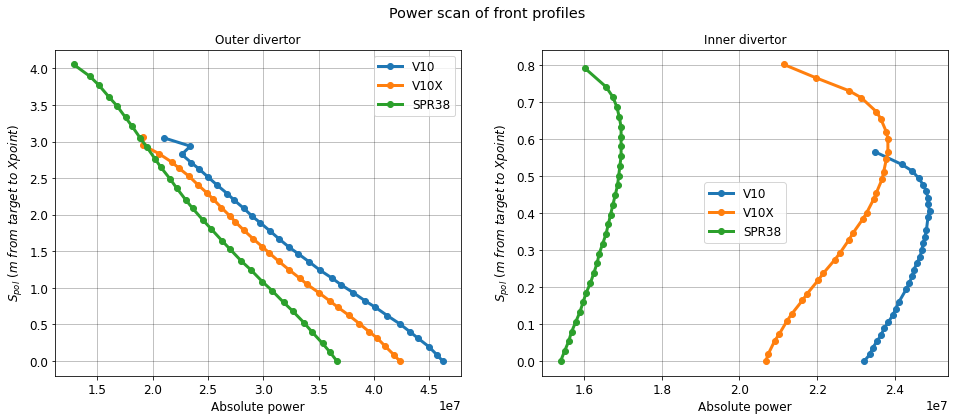

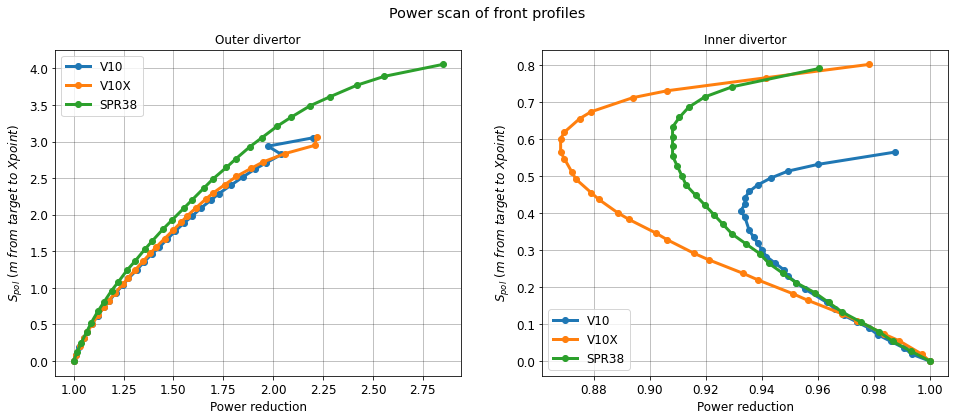

In [148]:
labels = {"cvar":"Absolute power", "crel":"Power reduction"}
for basis in ["cvar", "crel"]:

    fig, axes = plt.subplots(1,2, figsize = (16,6))
    fig.suptitle("Power scan of front profiles")
    ax = axes[0]
    for design in designs:
        for i, side in enumerate(["ou", "iu"]):
            o = scan_q[side][design].copy()
            if basis == "crel":
                axes[i].plot(1/o["out"][basis], o["out"]["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3)
            else:
                axes[i].plot(o["out"][basis], o["out"]["SpolPlot"],  marker = "o", label = design, markersize = 6, linewidth = 3)
            

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
        ax.legend()
        
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")